# Import

### Librerie

In [48]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, GRU, LSTM, Bidirectional
from keras.layers import Dropout
from keras.optimizers import Adam
from sklearn.metrics import *

### Dataset

In [49]:
dataset = pd.read_csv('dataset.csv')
dataset.set_index(['date', 'sex', 'age', 'height', 'timezone'], inplace=True)

In [50]:
test_split=round(len(dataset)*0.25)
df_for_training=dataset[:-test_split]
df_for_testing=dataset[-test_split:]
print("shape del training set: {}".format(df_for_training.shape))
print("shape del test set: {}".format(df_for_testing.shape))
dataset.head()

shape del training set: (704757, 6)
shape del test set: (234919, 6)


,,,,,steps,bedin,bedout,sleep duration,deepduration,lightduration
date,sex,age,height,timezone,,,,,,
2016-04-19,Male,39.0,174.0,PDT,7716.87,24.08,6.81,5.98,1.08,4.87
2016-04-20,Male,39.0,174.0,PDT,7647.55,27.36,6.50,3.00,1.61,1.37
2016-04-21,Male,39.0,174.0,PDT,6041.68,23.79,7.93,7.61,3.40,4.22
2016-04-22,Male,39.0,174.0,PDT,5094.85,25.94,6.44,4.59,1.28,3.33
2016-04-23,Male,39.0,174.0,PDT,4428.15,25.50,11.75,9.91,4.98,4.84


In [51]:
# Normalizzazione
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled= scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.35766577, 0.51965812, 0.42921147, 0.35860656, 0.15584416,
        0.61647362],
       [0.35445247, 0.8       , 0.40143369, 0.05327869, 0.23232323,
        0.16602317],
       [0.28001307, 0.49487179, 0.52956989, 0.52561475, 0.49062049,
        0.53281853],
       ...,
       [0.85629947, 0.48547009, 0.34318996, 0.38012295, 0.5036075 ,
        0.33719434],
       [0.63112802, 0.53247863, 0.47043011, 0.47745902, 0.58585859,
        0.38352638],
       [0.27716134, 0.31794872, 0.30286738, 0.53278689, 0.63347763,
        0.41570142]])

In [52]:
#n_past is the number of step we will look in the past to predict the next target value.
col2pred = 4  # 0:steps, 1:bedin, 2:bedout, 3:sleep duration, 4:deep duration, 5:lightduration
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            #per ogni feature fa l'append dei precedenti
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            
            dataY.append(dataset[i,col2pred])
    return np.array(dataX),np.array(dataY)

window_size = 7
trainX,trainY=createXY(df_for_training_scaled,window_size)
testX,testY=createXY(df_for_testing_scaled,window_size)

In [53]:
# features num
features_num = dataset.shape[1]

In [54]:
def model_recurrent(type = 1):
    model = Sequential()
    if type == 1:  # 1 = SimpleRNN
        model.add(SimpleRNN(50, return_sequences=True, input_shape=(window_size, features_num)))
        model.add(Dropout(0.2))

    if type == 2: # 2 = GRU
        model.add(GRU(50, return_sequences=True, input_shape=(window_size, features_num)))
        model.add(Dropout(0.2))

    if type == 3: # 3 = LSTM
        model.add(LSTM(50, return_sequences=True, input_shape=(window_size, features_num)))
        model.add(Dropout(0.2))

    if type == 4:  # 4 = 3xLSTM
        model.add(LSTM(256, return_sequences=True,input_shape=(window_size, features_num)))
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(64))
        model.add(Dropout(0.5))

    if type == 5: # Bidirectional
        model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(window_size, features_num)))

    model.add(Dense(1))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model 


model = model_recurrent(type=5)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100)              22800     
 l)                                                              
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 22,901
Trainable params: 22,901
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(trainX, trainY, epochs = 50, verbose = 1, batch_size = 4096) # 8192

Epoch 1/50
173/173 [==============================] - 15s 75ms/step - loss: 0.0264
Epoch 2/50
173/173 [==============================] - 14s 83ms/step - loss: 0.0151
Epoch 3/50
173/173 [==============================] - 14s 83ms/step - loss: 0.0150
Epoch 4/50
173/173 [==============================] - 15s 89ms/step - loss: 0.0150
Epoch 5/50
173/173 [==============================] - 16s 91ms/step - loss: 0.0150
Epoch 6/50
173/173 [==============================] - 15s 87ms/step - loss: 0.0149
Epoch 7/50
173/173 [==============================] - 15s 85ms/step - loss: 0.0149
Epoch 8/50
173/173 [==============================] - 15s 89ms/step - loss: 0.0149
Epoch 9/50
173/173 [==============================] - 15s 85ms/step - loss: 0.0149
Epoch 10/50
173/173 [==============================] - 15s 88ms/step - loss: 0.0149
Epoch 11/50
173/173 [==============================] - 15s 85ms/step - loss: 0.0149
Epoch 12/50
173/173 [==============================] - 15s 85ms/step - loss: 0.0149
E

In [58]:
prediction_train = model.predict(trainX)
print("prediction\n", prediction_train)
print("\nPrediction Shape-", prediction_train.shape)

prediction_train_copies_array = np.repeat(prediction_train, 6, axis=-1)
pred_train = scaler.inverse_transform(np.reshape(prediction_train_copies_array, (len(prediction_train), 6)))[:, col2pred]
true_value_train_copies_array = np.repeat(trainY, 6, axis=-1)
true_value_train = scaler.inverse_transform(np.reshape(true_value_train_copies_array, (len(trainY), 6)))[:, col2pred]

prediction_test=model.predict(testX)
print("prediction\n", prediction_test)
print("\nPrediction Shape-",prediction_test.shape)

prediction_copies_test_array = np.repeat(prediction_test,6, axis=-1)
pred_test=scaler.inverse_transform(np.reshape(prediction_copies_test_array,(len(prediction_test),6)))[:,col2pred]
true_value_test_copies_array = np.repeat(testY,6, axis=-1)
true_value_test=scaler.inverse_transform(np.reshape(true_value_test_copies_array,(len(testY),6)))[:,col2pred]

22024/22024 [==============================] - 33s 2ms/step
prediction
 [[0.4094858 ]
 [0.44226983]
 [0.4720221 ]
 ...
 [0.5200504 ]
 [0.49024397]
 [0.5119166 ]]

Prediction Shape- (704750, 1)
7341/7341 [==============================] - 10s 1ms/step
prediction
 [[0.5126177]
 [0.5233012]
 [0.5524079]
 ...
 [0.6371577]
 [0.6475355]
 [0.6632731]]

Prediction Shape- (234912, 1)


**********TRAIN-SET***********
MAE: 0.651
MSE: 0.707
RMSE: 0.841
**********TEST-SET***********
MAE: 0.663
MSE: 0.731
RMSE: 0.855


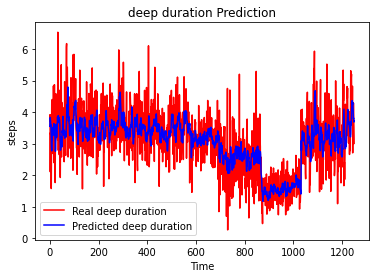

In [59]:
def metrics(true_value_train, pred_value_train, true_value_test, pred_value_test):
    print("**********TRAIN-SET***********")
    print("MAE: {:.3f}".format(mean_absolute_error(
        true_value_train, pred_value_train)))
    print("MSE: {:.3f}".format(
        mean_squared_error(true_value_train, pred_value_train)))
    print("RMSE: {:.3f}".format(
        mean_squared_error(true_value_train, pred_value_train, squared=False)))
    # metrics test set
    print("**********TEST-SET***********")
    print("MAE: {:.3f}".format(mean_absolute_error(
        true_value_test, pred_value_test)))
    print("MSE: {:.3f}".format(
        mean_squared_error(true_value_test, pred_value_test)))
    print("RMSE: {:.3f}".format(
        mean_squared_error(true_value_test, pred_value_test, squared=False)))
    

    plt.plot(true_value_test[:1250], color='red', label='Real deep duration')
    plt.plot(pred_value_test[:1250], color='blue', label='Predicted deep duration')
    plt.title('deep duration Prediction')
    plt.xlabel('Time')
    plt.ylabel('steps')
    plt.legend()
    plt.show()


metrics(true_value_train, pred_train, true_value_test, pred_test)